# TO DO:
- Appropriately chop up and lay out the Activity Regression Plot
- Look at dynamics plots in clear stim paradigm (requires running CCA on this data first) 
    - Would like to say "there's still two groups of distinguishable neurons, but their dynamics are more similar and their roles are different in decoding"

In [ ]:
import pickle
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import glob as glob
import os
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from collections import defaultdict
from scipy.linalg import subspace_angles
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [ ]:
manual_dimesnsion = 39

### Load consolidated dimreduc dataframe

In [ ]:
dimreduc_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output/dimreduc_deg_final_analysis_230322_214006_Jamie/dimreduc_deg_final_analysis_230322_214006_Jamie_glom.pickle'
with open(dimreduc_glom_path, 'rb') as f:
    dat = pickle.load(f) 
df_dimreduc = pd.DataFrame(dat) 

### Load the processed data from both regions

In [ ]:
def make_hashable(obj):
    if isinstance(obj, dict):
        return tuple(sorted((key, make_hashable(value)) for key, value in obj.items()))
    elif isinstance(obj, (list, tuple)):
        return tuple(make_hashable(item) for item in obj)
    else:
        return obj


unique_hashes = set(make_hashable(d) for d in df_dimreduc['full_arg_tuple'])
unique_dicts = [dict(u) for u in unique_hashes]
preload_dict_path = df_dimreduc['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)

In [ ]:
for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)


##### Sum spike rate per trial

In [ ]:
AM_spikes = np.sum(AM_loaded_data['spike_rates'], 1)
ML_spikes = np.sum(ML_loaded_data['spike_rates'], 1)


all_spikes = {'AM':AM_spikes, 'ML':ML_spikes}

### Load CCA model

In [ ]:
ccamodel_dir = df_dimreduc['results_file'][0]
CCA_dims = manual_dimesnsion #None

if CCA_dims == None:
    ccamodel_path = glob.glob(ccamodel_dir+"/CCA_*.pickle")[0]
else:
    ccamodel_path = os.path.dirname(ccamodel_dir)+f"/CCA_{CCA_dims}_dims.pickle"

with open(ccamodel_path, 'rb') as file:
    ccamodel = pickle.load(file)

In [ ]:
dimensions = np.unique(df_dimreduc['dim'])
n_folds = np.unique(df_dimreduc['fold_idx'])
regions = np.unique(df_dimreduc['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_dimreduc['dimreduc_method'])
proj_methods = np.append(dimreduc_methods, 'CCA')

# Using ideal dimension for across region comparison

In [ ]:
DIM = 21
all_comparisons_0_1 = []
all_comparisons_1_0 = []

proj_correlations = {}


combo_ind = 0
region_method_pairs = set()  # Set to keep track of seen combinations
for region0, region1, method0, method1 in itertools.product(regions, regions, proj_methods, proj_methods):
    sorted_0 = tuple(sorted([region0, method0]))
    sorted_1 = tuple(sorted([region1, method1]))
    
    combo = (tuple(sorted((sorted_0, sorted_1))))
    
    if combo in region_method_pairs:
        continue  
    elif region0 == region1 and method0 == method1:
        continue
    region_method_pairs.add(combo)
    

    n_fold_r2_0_1 = np.zeros(len(n_folds))
    n_fold_r2_1_0 = np.zeros(len(n_folds))
    avg_correlations = np.zeros(len(n_folds))
    
    
    for n_fold in n_folds:

        if method0 == 'CCA' and method1 == 'CCA':

            if region0 == 'ML':
                ProjMat0 = ccamodel.x_rotations_
                ProjMat1 = ccamodel.y_rotations_

            elif region0 == 'AM':
                ProjMat0 = ccamodel.y_rotations_
                ProjMat1 = ccamodel.x_rotations_

        elif method0 == 'CCA':
            ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == DIM) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]
            if region0 == 'ML':
                ProjMat0 = ccamodel.x_rotations_
            elif region0 == 'AM':
                ProjMat0 = ccamodel.y_rotations_

        elif method1 == 'CCA':
            ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == DIM) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
            if region1 == 'ML':
                ProjMat1 = ccamodel.x_rotations_
            elif region1 == 'AM':
                ProjMat1 = ccamodel.y_rotations_
        else:
            ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == DIM) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
            ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == DIM) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]

        projData0 = all_spikes[region0] @ ProjMat0[:,0:DIM]
        projData1 = all_spikes[region1] @ ProjMat1[:,0:DIM]


        model_0_1 = LinearRegression()
        model_0_1.fit(projData0, projData1)
        r2_0_1 = model_0_1.score(projData0, projData1)
        
        model_1_0 = LinearRegression()
        model_1_0.fit(projData1, projData0)
        r2_1_0 = model_1_0.score(projData1, projData0)

        correlations = []
        for row_x, row_y in zip(projData0, projData1):
            corr, _ = pearsonr(row_x, row_y)
            correlations.append(corr)
        average_correlation = np.mean(correlations)


        avg_correlations[n_fold] = average_correlation
        n_fold_r2_0_1[n_fold] = r2_0_1
        n_fold_r2_1_0[n_fold] = r2_1_0

        

    R2_avg_0_1 = np.mean(n_fold_r2_0_1)
    R2_avg_1_0 = np.mean(n_fold_r2_1_0)

    all_comparisons_0_1.append(R2_avg_0_1)
    all_comparisons_1_0.append(R2_avg_1_0)

    #models[f"{region0}_{method0}_{region1}_{method1}"] = model_0_1
    proj_correlations[f"{region0}_{method0}_{region1}_{method1}"] = np.mean(avg_correlations)
        
    combo_ind += 1

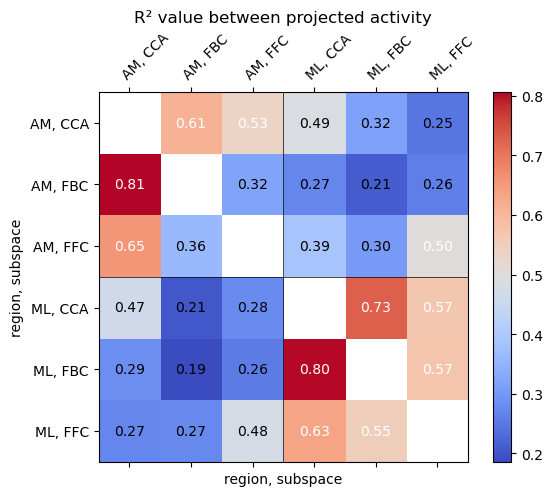

In [ ]:
unique_groups = [('AM', 'CCA'), ('AM', 'LQGCA'), ('AM', 'PCA'), ('ML', 'CCA'), ('ML', 'LQGCA'), ('ML', 'PCA')]
unique_group_labels = [('AM', 'CCA'), ('AM', 'FBC'), ('AM', 'FFC'), ('ML', 'CCA'), ('ML', 'FBC'), ('ML', 'FFC')]

group_indices = {group: i for i, group in enumerate(unique_groups)}

n = 6  # We have 6 unique groups
matrix = np.zeros((n, n))  # Initialize the matrix with zeros

correlation_index = 0
for i in range(n):
    for j in range(i + 1, n):
        matrix[i, j] = all_comparisons_0_1[correlation_index]
        matrix[j, i] = all_comparisons_1_0[correlation_index]  # Not Symmetric
        correlation_index += 1

# Set diagonal values to NaN
np.fill_diagonal(matrix, np.nan)

labels = [f"{reg}, {meth}" for reg, meth in unique_group_labels]

fig, ax = plt.subplots()
cax = ax.matshow(matrix, cmap='coolwarm')
plt.colorbar(cax)

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(labels, rotation=45, ha="left", rotation_mode="anchor")
ax.set_yticklabels(labels)

# Annotate each cell with the numeric value
for (i, j), val in np.ndenumerate(matrix):
    if not np.isnan(val):  # Skip NaN values
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')

midpoint = n / 2
ax.axhline(midpoint - 0.5, color='black', linewidth=0.5)  # Horizontal line
ax.axvline(midpoint - 0.5, color='black', linewidth=0.5)  # Vertical line

plt.title(f'R² value between projected activity')
plt.xlabel('region, subspace')
plt.ylabel('region, subspace')
plt.show()


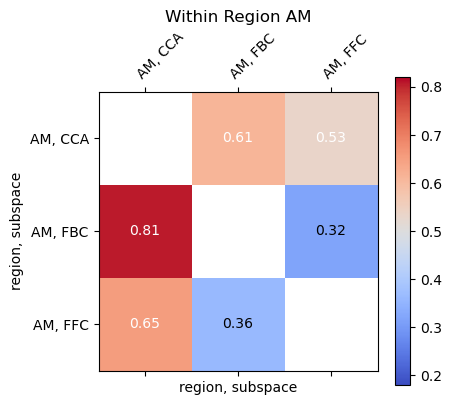

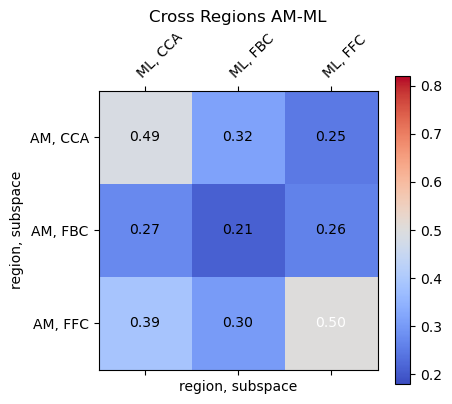

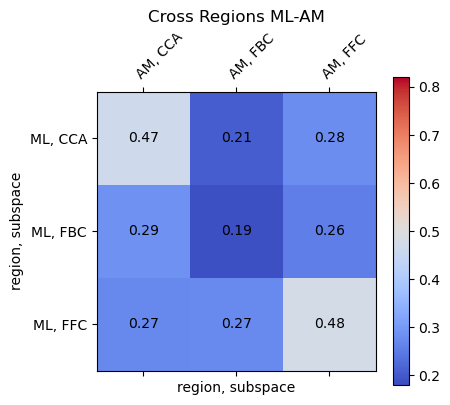

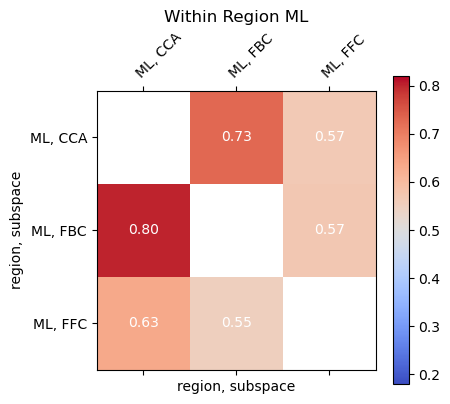

In [ ]:
unique_groups = [('AM', 'CCA'), ('AM', 'LQGCA'), ('AM', 'PCA'), ('ML', 'CCA'), ('ML', 'LQGCA'), ('ML', 'PCA')]
unique_group_labels = [('AM', 'CCA'), ('AM', 'FBC'), ('AM', 'FFC'), ('ML', 'CCA'), ('ML', 'FBC'), ('ML', 'FFC')]

group_indices = {group: i for i, group in enumerate(unique_groups)}

n = 6  # We have 6 unique groups
matrix = np.zeros((n, n))  # Initialize the matrix with zeros

correlation_index = 0
for i in range(n):
    for j in range(i + 1, n):
        matrix[i, j] = all_comparisons_0_1[correlation_index]
        matrix[j, i] = all_comparisons_1_0[correlation_index]  # Not Symmetric
        correlation_index += 1

# Set diagonal values to NaN
np.fill_diagonal(matrix, np.nan)

labels = [f"{reg}, {meth}" for reg, meth in unique_group_labels]

# Split the matrix into four 3x3 submatrices
submatrices = [
    matrix[:3, :3],
    matrix[:3, 3:],
    matrix[3:, :3],
    matrix[3:, 3:]
]

sub_labels = [
    labels[:3],
    labels[:3],  # Cross Region AM-ML: X-axis labels for AM, Y-axis labels for ML
    labels[3:],  # Cross Region ML-AM: X-axis labels for ML, Y-axis labels for AM
    labels[3:]
]

# Adjust titles for clarity
titles = ["Within Region AM", "Cross Regions AM-ML", "Cross Regions ML-AM", "Within Region ML"]

# Plotting four 3x3 heatmaps as separate figures with a fixed colorbar range
for i in range(4):
    fig, ax = plt.subplots(figsize=(4.5, 4))
    cax = ax.matshow(submatrices[i], cmap='coolwarm', vmin=0.18, vmax=0.82)
    fig.colorbar(cax, ax=ax)

    ax.set_xticks(range(3))
    ax.set_yticks(range(3))

    # Adjust labels for cross-region plots
    if i == 1:  # Cross Regions AM-ML
        ax.set_xticklabels(labels[3:], rotation=45, ha="left", rotation_mode="anchor")
        ax.set_yticklabels(labels[:3])
    elif i == 2:  # Cross Regions ML-AM
        ax.set_xticklabels(labels[:3], rotation=45, ha="left", rotation_mode="anchor")
        ax.set_yticklabels(labels[3:])
    else:  # Within Region plots
        ax.set_xticklabels(sub_labels[i], rotation=45, ha="left", rotation_mode="anchor")
        ax.set_yticklabels(sub_labels[i])

    # Annotate each cell with the numeric value
    for (x, y), val in np.ndenumerate(submatrices[i]):
        if not np.isnan(val):  # Skip NaN values
            ax.text(y, x, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')

    # Adding title and labels
    plt.title(titles[i])
    plt.xlabel('region, subspace')
    plt.ylabel('region, subspace')
    plt.show()
